# Comma.ai Accelerometer -> Steering Angle

We'd like to be able to predict the steering angle of the car from the accelerometer data of a device on board. We may need to include the speed of the car as input to disambiguate between (low speed, sharp turn) and (high speed, shallow turn), but we can try both out to see what works best.

## Prelude

Imports, functions.

In [43]:
import numpy as np
import pandas as pd
import h5py
from os import listdir
from os.path import isfile, isdir, join
import matplotlib.pyplot as plt
%matplotlib inline

## Data Exploration

In [3]:
data_dir = 'dataset/log/'
files = [f for f in listdir(data_dir) if isfile(join(data_dir, f))]

In [4]:
files

['2016-02-08--14-56-28.h5',
 '2016-06-02--21-39-29.h5',
 '2016-01-31--19-19-25.h5',
 '2016-04-21--14-48-08.h5',
 '2016-05-12--22-20-00.h5',
 '2016-02-11--21-32-47.h5',
 '2016-06-08--11-46-01.h5',
 '2016-01-30--13-46-00.h5',
 '2016-01-30--11-24-51.h5',
 '2016-02-02--10-16-58.h5',
 '2016-03-29--10-50-20.h5']

In [35]:
f = h5py.File(join(data_dir, files[0]), 'r')

In [37]:
for key in f.keys():
    print('key: {}\n\t{}'.format(key, f[key].shape))

key: UN_D_cam1_ptr
	(25866,)
key: UN_D_cam2_ptr
	(25856,)
key: UN_D_camphone_ptr
	(38558,)
key: UN_D_lidar_ptr
	(2338820,)
key: UN_D_radar_msg
	(341978, 7)
key: UN_D_rawgps
	(54044,)
key: UN_T_cam1_ptr
	(25866,)
key: UN_T_cam2_ptr
	(25856,)
key: UN_T_camphone_ptr
	(38558,)
key: UN_T_lidar_ptr
	(2338820,)
key: UN_T_radar_msg
	(341978,)
key: UN_T_rawgps
	(54044,)
key: blinker
	(129344,)
key: brake
	(129344,)
key: brake_computer
	(129344,)
key: brake_user
	(129344,)
key: cam1_ptr
	(129344,)
key: cam2_ptr
	(129344,)
key: camphone_ptr
	(129344,)
key: car_accel
	(129344,)
key: fiber_accel
	(129344, 3)
key: fiber_compass
	(129344, 3)
key: fiber_compass_x
	(129344,)
key: fiber_compass_y
	(129344,)
key: fiber_compass_z
	(129344,)
key: fiber_gyro
	(129344, 3)
key: fiber_temperature
	(129344,)
key: gas
	(129344,)
key: gear_choice
	(129344,)
key: gps_1_fix
	(129344,)
key: gps_1_pos
	(129344, 3)
key: gps_1_vel
	(129344, 3)
key: gps_2_fix
	(129344,)
key: gps_2_pos
	(129344, 3)
key: gps_2_vel
	(12934

In [38]:
accel = np.array(f['imu_accel'])
x, y, z = (accel[:, 0], accel[:, 1], accel[:, 2])
data = {'steering_angle': f['steering_angle'], 'x': x, 'y': y, 'z': z}
angle_data = pd.DataFrame(data)

In [39]:
angle_data.head()

,steering_angle,x,y,z
0,-3426.0,-1.210000,9.470000,-1.000000
1,-3426.0,-1.220000,9.464167,-0.968611
2,-3426.0,-1.219803,9.490197,-0.961377
3,-3426.0,-1.215939,9.500000,-1.053755
4,-3426.0,-1.230000,9.500848,-1.102372


In [40]:
f.close()

In [41]:
angle_data['steering_angle'].min()

-5111.8364744743139

(array([  1.29000000e+02,   2.90000000e+01,   5.87000000e+02,
          1.93000000e+02,   3.56000000e+02,   5.81000000e+02,
          1.26143000e+05,   4.75000000e+02,   3.16000000e+02,
          5.35000000e+02]),
 array([-5111.83647447, -4335.45282703, -3559.06917958, -2782.68553213,
        -2006.30188468, -1229.91823724,  -453.53458979,   322.84905766,
         1099.23270511,  1875.61635255,  2652.        ]),
 <a list of 10 Patch objects>)

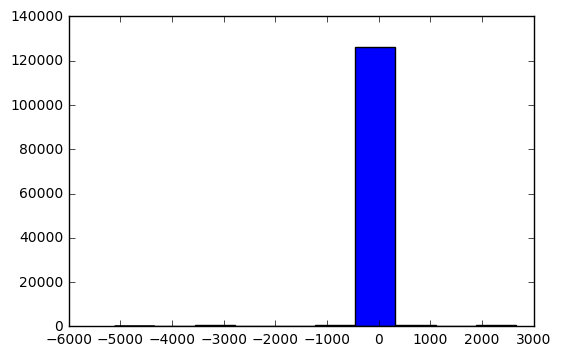

In [44]:
plt.hist(angle_data['steering_angle'])

(array([ 129.,   29.,  587.,  193.,  356.,  506.,    0.,  298.,  316.,  535.]),
 array([-5111.83647447, -4335.45282703, -3559.06917958, -2782.68553213,
        -2006.30188468, -1229.91823724,  -453.53458979,   322.84905766,
         1099.23270511,  1875.61635255,  2652.        ]),
 <a list of 10 Patch objects>)

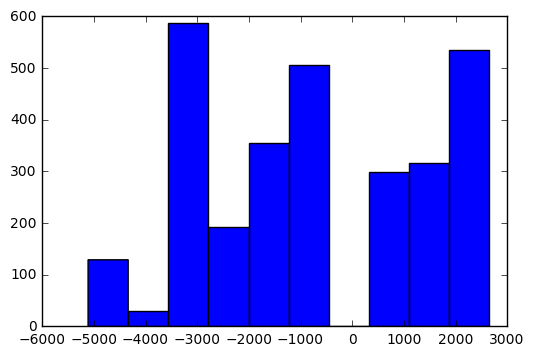

In [54]:
plt.hist(angle_data[angle_data['steering_angle'].abs() > 500]['steering_angle'])

In [42]:
angle_data['steering_angle'].max()

2652.0

In [55]:
extreme = angle_data[angle_data['steering_angle'].abs() > 500]

## Linear Model

In [75]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [67]:
train_x, test_x, train_y, test_y = train_test_split(extreme.iloc[:, 1:], extreme['steering_angle'], test_size=0.1)

In [68]:
lm = LinearRegression()
lm.fit(train_x, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [69]:
np.sqrt(mean_squared_error(lm.predict(train_x), train_y))

1976.2710556861848

In [70]:
preds = lm.predict(test_x)

In [73]:
np.sqrt(mean_squared_error(preds, test_y))

1915.4940886521433

## Logistic Regression


In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [96]:
extreme.loc[:, 'turn'] = (np.sign(extreme.loc[:, 'steering_angle']) + 1) / 2
extreme['turn'] = extreme['turn'].astype(int)

/Users/kevinrtai/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/pandas/core/indexing.py:549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/Users/kevinrtai/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [98]:
train_x, test_x, train_y, test_y = train_test_split(extreme.iloc[:, 1:], extreme['turn'], test_size=0.1)

In [99]:
lreg = LogisticRegression()
lreg.fit(train_x, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [111]:
roc_auc_score(train_y, lreg.predict_proba(train_x)[:, 1])

1.0

In [112]:
roc_auc_score(test_y, lreg.predict_proba(test_x)[:, 1])

1.0